In [74]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor
import matplotlib.pyplot as plt

import scienceplots
import numpy as np

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False

from sklearn.model_selection import train_test_split

In [75]:
import matplotlib.pyplot as plt
import scienceplots
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

In [76]:
def coverage_fraction(y, y_low, y_high):
    """https://scikit-learn.org/1.5/auto_examples/ensemble/plot_gradient_boosting_quantile.html#calibration-of-the-confidence-interval"""
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [77]:
def objective(trial, X, y, alpha, scoring_fn, random_state):
    # Define hyperparameter search space
    # params = {
    #     'n_estimators':...
    # }
    # max_iter = trial.suggest_int("max_iter", 50, 200)

    # works but slow
    # n_estimators = trial.suggest_int("n_estimators", 50, 500)
    # max_depth = trial.suggest_int("max_depth", 5, 20)

    n_estimators = trial.suggest_int("n_estimators", 1, 100)
    max_depth = trial.suggest_int("max_depth", 20, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)

    # Create Gradient Boosting Regressor with the suggested hyperparameters
    model = GradientBoostingRegressor(
        loss="quantile",
        alpha=alpha,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
        # **params
    )
    # model = HistGradientBoostingRegressor(
    #     loss="quantile",
    #     quantile=alpha,
    #     max_iter=max_iter,
    #     max_depth=max_depth,
    #     learning_rate=learning_rate,
    #     random_state=42,
    # )

    # Evaluate the model using cross-validation
    # I think the mean is taken across k-folds
    score = cross_val_score(model, X, y, cv=3, scoring=scoring_fn).mean()

    return score  # We are maximising with Optuna


def optimise_quantile_regressor(X, y, alpha, n_trials, random_state=42):
    neg_mean_pinball_loss_alpha = make_scorer(
        mean_pinball_loss, alpha=alpha, greater_is_better=False
    )

    # Create a study object
    study = optuna.create_study(direction="maximize")

    # Run the optimization process
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(
        lambda trial: objective(trial, X, y, alpha, neg_mean_pinball_loss_alpha, random_state),
        n_trials=n_trials,
        show_progress_bar=True,
        # n_jobs=4,
    )

    # Print the best hyperparameters and score
    print("Best hyperparameters:", study.best_params)
    print("Best score:", study.best_value)

    # Create the final model with the best hyperparameters
    best_model = GradientBoostingRegressor(
        random_state=random_state, loss="quantile", alpha=alpha, **study.best_params
    )
    # best_model = HistGradientBoostingRegressor(
    #     random_state=random_state, loss="quantile", quantile=alpha, **study.best_params
    # )
    best_model.fit(X, y)
    return best_model



In [78]:

def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [79]:
mask = (X_train[:, 0] > 4) & (X_train[:, 0] < 6)
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (X_test[:, 0] > 4) & (X_test[:, 0] < 6)
X_test = X_test[~mask]
y_test = y_test[~mask]


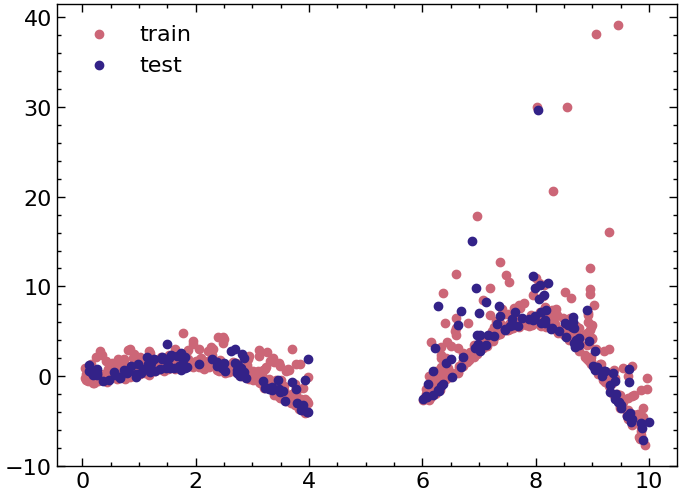

In [80]:
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.legend()
plt.show()

Set up EQR model for data augmentation / synthetic data generation

In [81]:
# the domain that your model will have calibrated uncertainties over
bounds = [(-5, 15)]
# how many synthetic samples to augment your training data
n_synth = 500
# method='gbr'
# method='ann'
method='lgb'
eqr_model = EpistemicQuantileRegressor(bounds, n_synth, method)

In [82]:


X_ood, y_ood = eqr_model.generate_synthetic_ood_data(X_train, y_train, scaling_factor=2)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)




In [83]:
X_train.shape, X_test.shape, X_ood.shape, X_aug.shape

((606, 1), (202, 1), (297, 1), (903, 1))

# train on train data

In [84]:
%%time
if method == "ann":
    params = dict(epochs=100, batch_size=128, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=20,
        verbose=-1,
    )
else:
    raise ValueError(f"unknown {method = }")

alphas=[0.05, 0.5, 0.95]

eqr_model.fit(X_train, y_train, **params)

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 46.7 s, sys: 1min 43s, total: 2min 30s
Wall time: 1min 21s


In [85]:
for k in eqr_model.study.keys():
    print(k, eqr_model.study[k].best_params)

0.05 {'num_boost_round': 83, 'num_leaves': 5711, 'min_data_in_leaf': 22}
0.5 {'num_boost_round': 93, 'num_leaves': 4344, 'min_data_in_leaf': 21}
0.95 {'num_boost_round': 55, 'num_leaves': 7933, 'min_data_in_leaf': 81}


In [86]:
xx = np.linspace(-5, 15, 100)[:, np.newaxis]
yhats_initial = {alpha: eqr_model.models[alpha].predict(xx) for alpha in alphas}

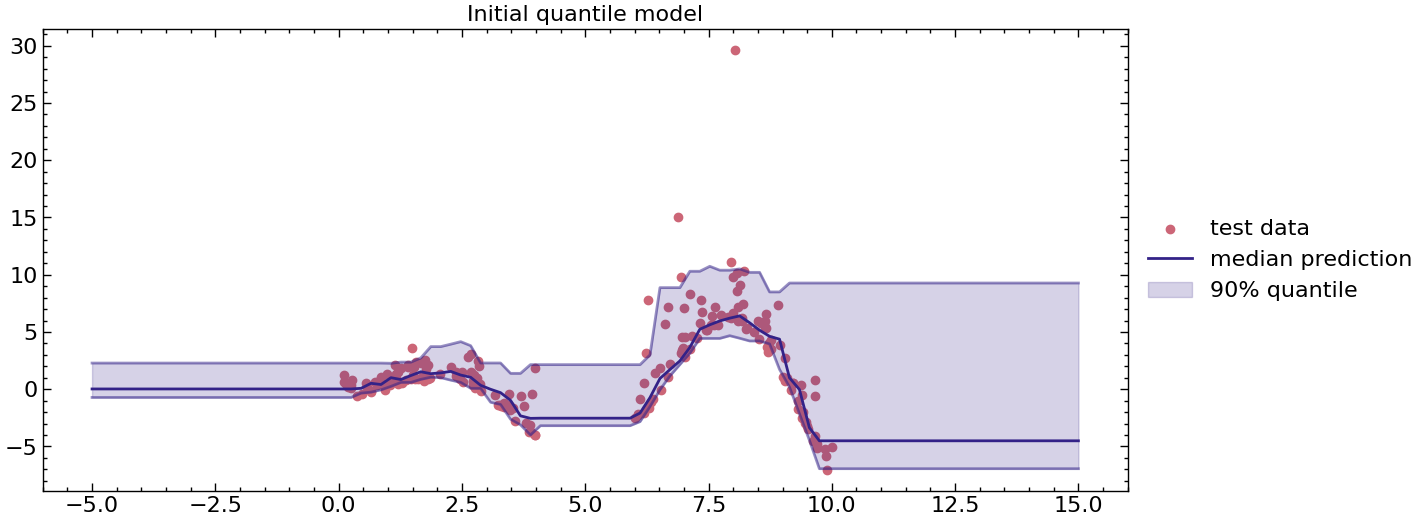

In [87]:
plt.figure(figsize=(14, 6))
plt.scatter(X_test, y_test, c="C0", label='test data')
plt.plot(xx, yhats_initial[0.05], c="C1", alpha=0.5)
plt.plot(xx, yhats_initial[0.5], c="C1", label='median prediction')
plt.plot(xx, yhats_initial[0.95], c="C1", alpha=0.5)
plt.fill_between(xx[:, 0], yhats_initial[0.05], yhats_initial[0.95], color="C1", alpha=0.2, label='90% quantile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-15, 15)
# plt.xlim(0, 10)
plt.title("Initial quantile model")
plt.show()
plt.close()

In [88]:
# estimates of uncertainty

total_uncertainty = yhats_initial[0.95] - yhats_initial[0.05]

xx_ll = eqr_model.gmm.score_samples(xx)
mask_in_domain = xx_ll > eqr_model.threshold_ll
xx_in_domain = xx[mask_in_domain]
xx_out_domain = xx[~mask_in_domain]

stat_uncert = total_uncertainty[mask_in_domain]
sys_uncert = total_uncertainty[~mask_in_domain]

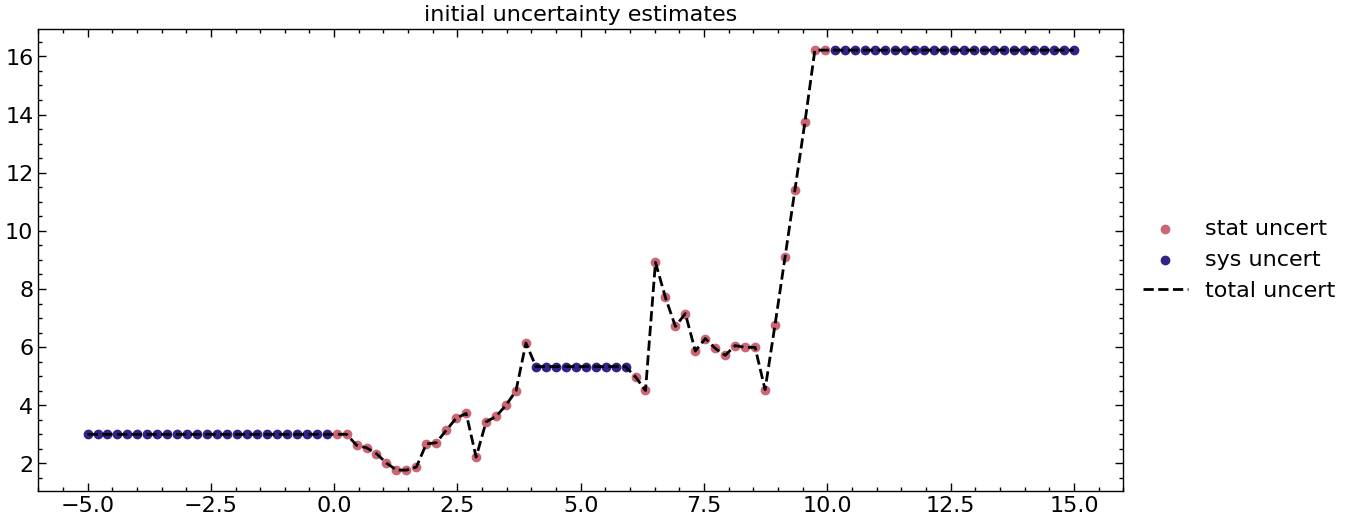

In [89]:
plt.figure(figsize=(14, 6))
plt.scatter(xx_in_domain, stat_uncert, label="stat uncert")
plt.scatter(xx_out_domain, sys_uncert, label="sys uncert")
plt.plot(xx, total_uncertainty, label="total uncert", c="k", ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(0, 50)
plt.title("initial uncertainty estimates")
plt.show()


In [90]:

yhats = {alpha: eqr_model.models[alpha].predict(X_train) for alpha in alphas}


coverage_fraction(
    y_train,
    yhats[0.05],
    yhats[0.95],
)

0.8861386138613861

In [91]:
yhats = {alpha: eqr_model.models[alpha].predict(X_test) for alpha in alphas}

coverage_fraction(
    y_test,
    yhats[0.05],
    yhats[0.95],
)

0.806930693069307

# train on augmented data

In [55]:
X_train.shape

(606, 1)

In [56]:
X_test.shape

(202, 1)

In [57]:
X_ood.shape

(305, 1)

In [58]:
X_aug.shape

(911, 1)

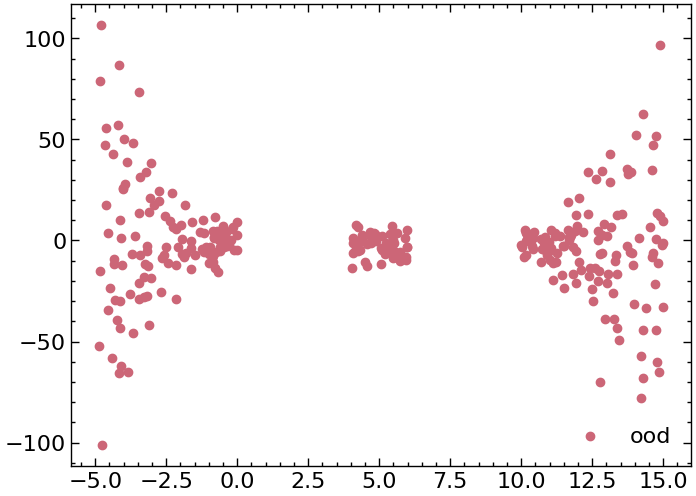

In [59]:
plt.figure()
plt.scatter(X_ood, y_ood, label="ood")
plt.legend()
plt.show()

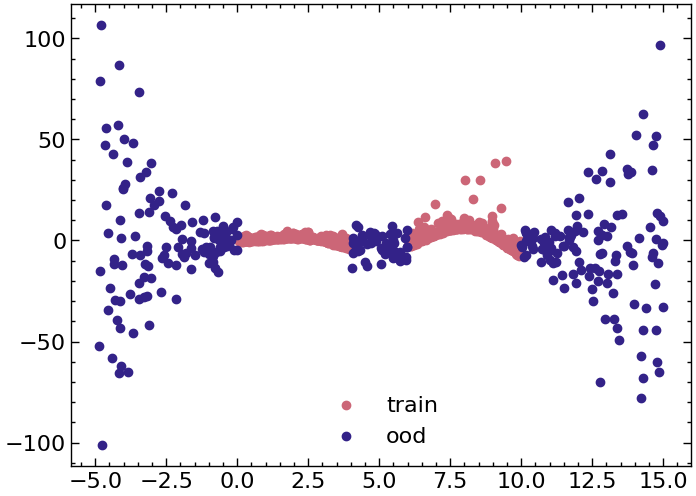

In [60]:
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
# plt.ylim(-10, 10)
# plt.xlim(0, 10)
plt.legend()
plt.show()

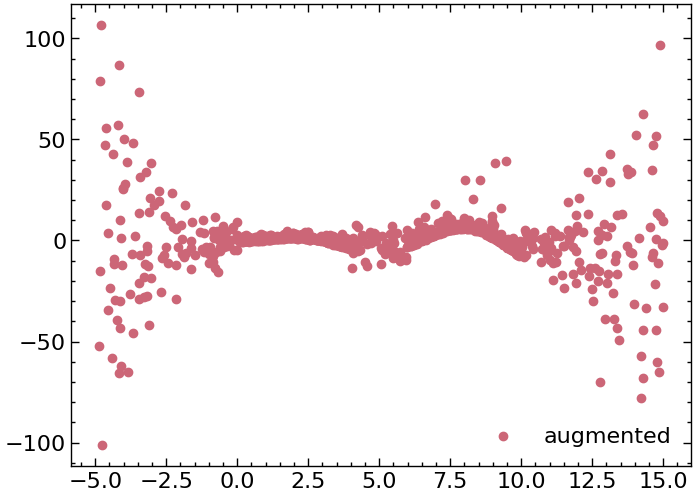

In [61]:
plt.figure()
plt.scatter(X_aug, y_aug, label="augmented")
plt.legend()
plt.show()

In [62]:
%%time
if method == "ann":
    params = dict(epochs=100, batch_size=128, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=20,
        verbose=-1,
    )
else:
    raise ValueError(f"unknown {method = }")

alphas = [0.05,0.5,0.95]
eqr_model.fit(X_aug, y_aug, **params)

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 44 s, sys: 1min 37s, total: 2min 21s
Wall time: 1min 19s


In [73]:
for k in eqr_model.study.keys():
    print(k, eqr_model.study[k].best_params)

0.05 {'num_boost_round': 90, 'num_leaves': 6408, 'min_data_in_leaf': 22}
0.5 {'num_boost_round': 176, 'num_leaves': 2689, 'min_data_in_leaf': 88}
0.95 {'num_boost_round': 46, 'num_leaves': 5258, 'min_data_in_leaf': 31}


In [63]:
xx = np.linspace(-5, 15, 100)[:, np.newaxis]
yhats = {alpha: eqr_model.models[alpha].predict(xx) for alpha in alphas}


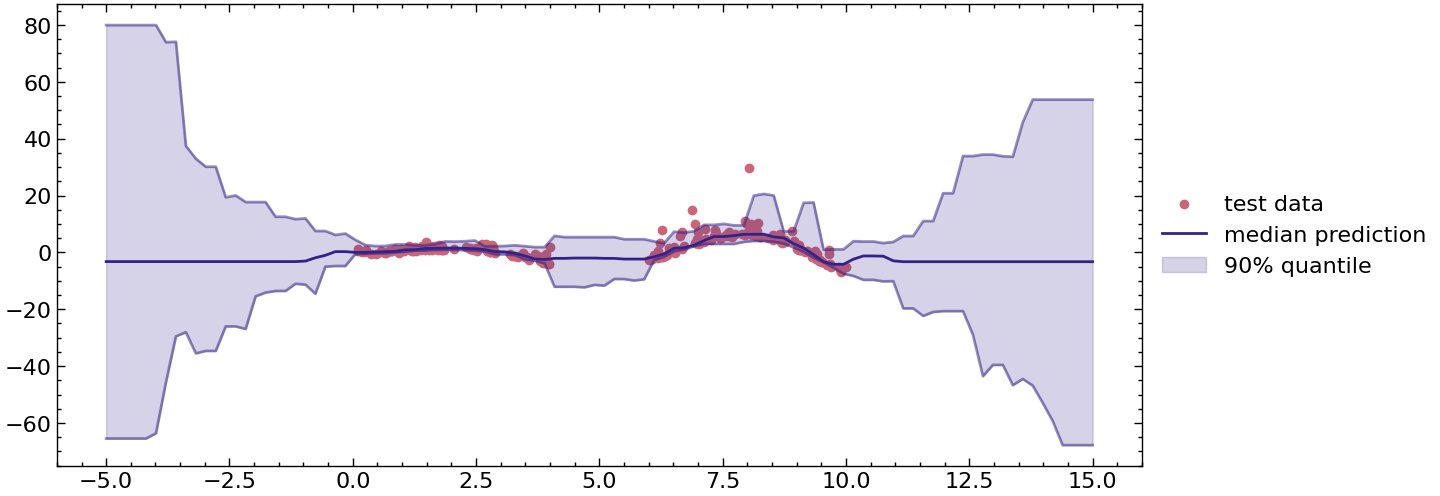

In [64]:
plt.figure(figsize=(14, 6))
plt.scatter(X_test, y_test, c="C0", label='test data')
plt.plot(xx, yhats[0.05], c="C1", alpha=0.5)
plt.plot(xx, yhats[0.5], c="C1", label='median prediction')
plt.plot(xx, yhats[0.95], c="C1", alpha=0.5)
plt.fill_between(xx[:, 0], yhats[0.05], yhats[0.95], color="C1", alpha=0.2, label='90% quantile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

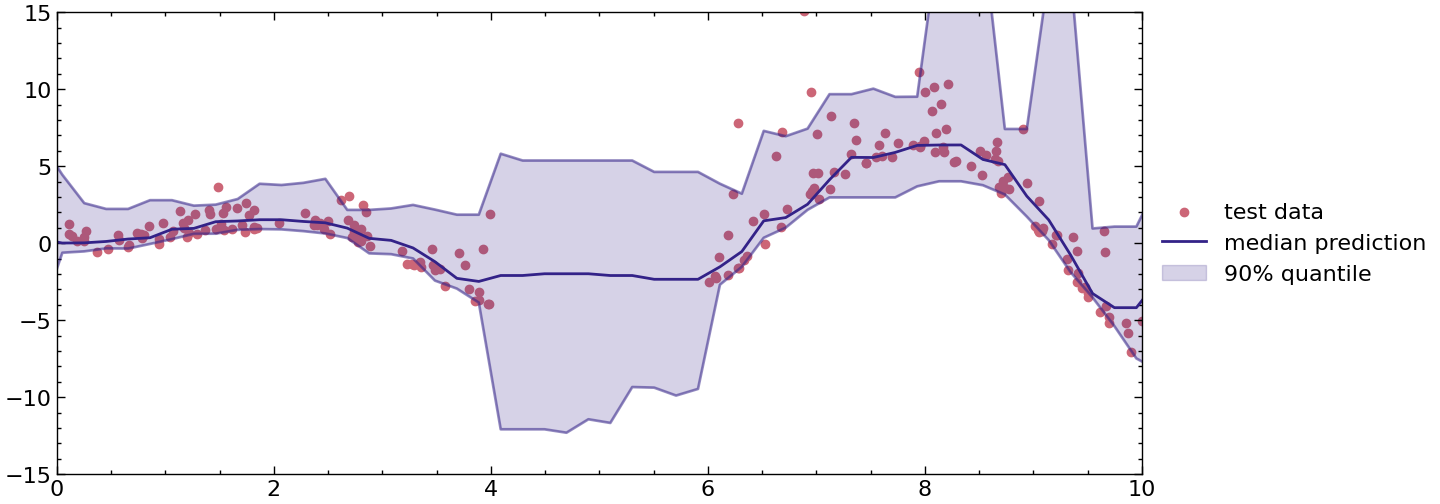

In [65]:
plt.figure(figsize=(14, 6))
plt.scatter(X_test, y_test, c="C0", label='test data')
plt.plot(xx, yhats[0.05], c="C1", alpha=0.5)
plt.plot(xx, yhats[0.5], c="C1", label='median prediction')
plt.plot(xx, yhats[0.95], c="C1", alpha=0.5)
plt.fill_between(xx[:, 0], yhats[0.05], yhats[0.95], color="C1", alpha=0.2, label='90% quantile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-15, 15)
plt.xlim(0, 10)
plt.show()
plt.close()

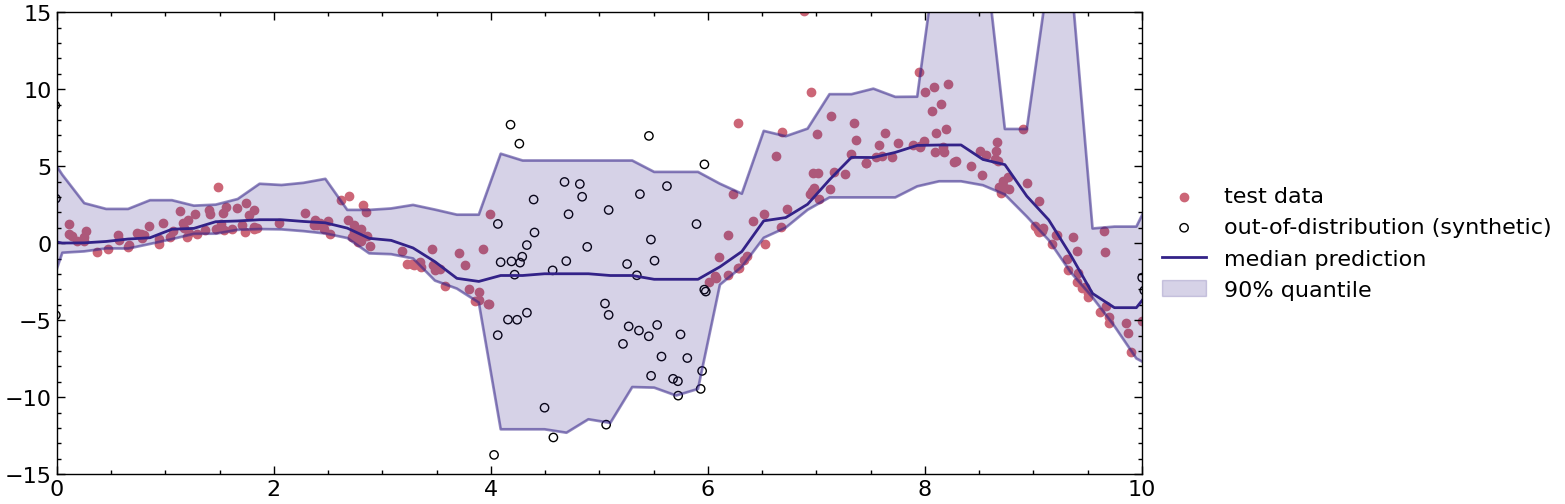

In [66]:
plt.figure(figsize=(14, 6))
plt.scatter(X_test, y_test, c="C0", label='test data')
plt.scatter(X_ood, y_ood, fc='none', ec='k', label='out-of-distribution (synthetic)')
plt.plot(xx, yhats[0.05], c="C1", alpha=0.5)
plt.plot(xx, yhats[0.5], c="C1", label='median prediction')
plt.plot(xx, yhats[0.95], c="C1", alpha=0.5)
plt.fill_between(xx[:, 0], yhats[0.05], yhats[0.95], color="C1", alpha=0.2, label='90% quantile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-15, 15)
plt.xlim(0, 10)
plt.show()
plt.close()

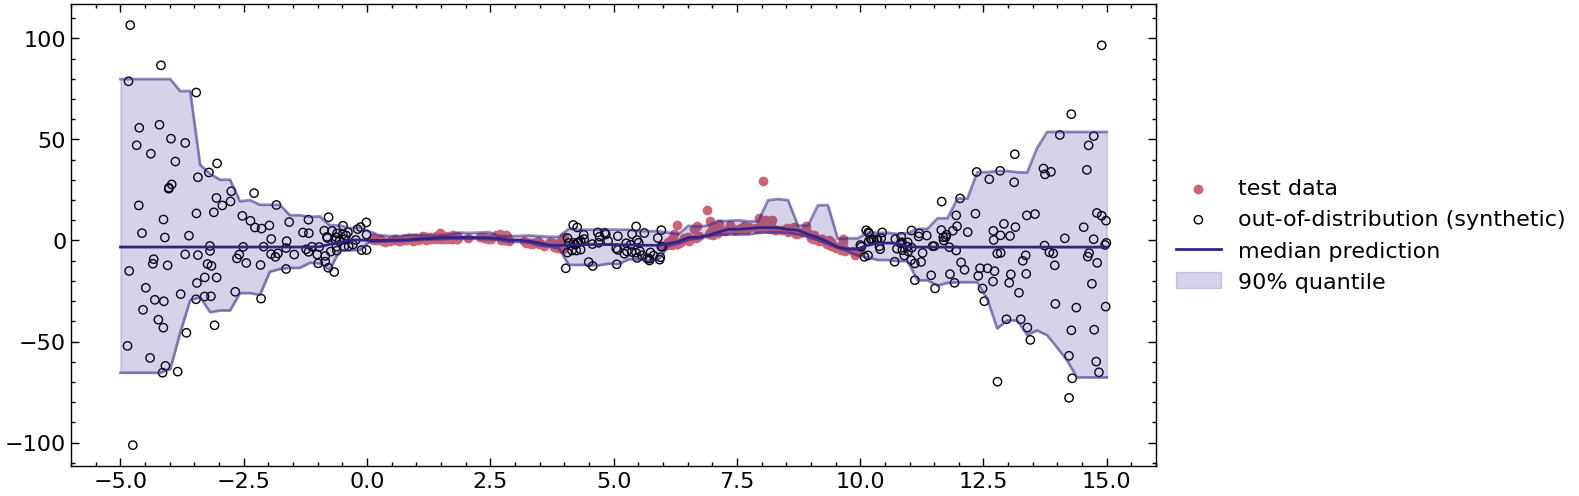

In [67]:
plt.figure(figsize=(14, 6))
plt.scatter(X_test, y_test, c="C0", label='test data')
plt.scatter(X_ood, y_ood, fc='none', ec='k', label='out-of-distribution (synthetic)')
plt.plot(xx, yhats[0.05], c="C1", alpha=0.5)
plt.plot(xx, yhats[0.5], c="C1", label='median prediction')
plt.plot(xx, yhats[0.95], c="C1", alpha=0.5)
plt.fill_between(xx[:, 0], yhats[0.05], yhats[0.95], color="C1", alpha=0.2, label='90% quantile')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-15, 15)
# plt.xlim(0, 10)
plt.show()
plt.close()

In [68]:
# estimates of uncertainty



total_uncertainty = yhats[0.95] - yhats[0.05]

xx_ll = eqr_model.gmm.score_samples(xx)
mask_in_domain = xx_ll > eqr_model.threshold_ll
xx_in_domain = xx[mask_in_domain]
xx_out_domain = xx[~mask_in_domain]

stat_uncert = total_uncertainty[mask_in_domain]
sys_uncert = total_uncertainty[~mask_in_domain]

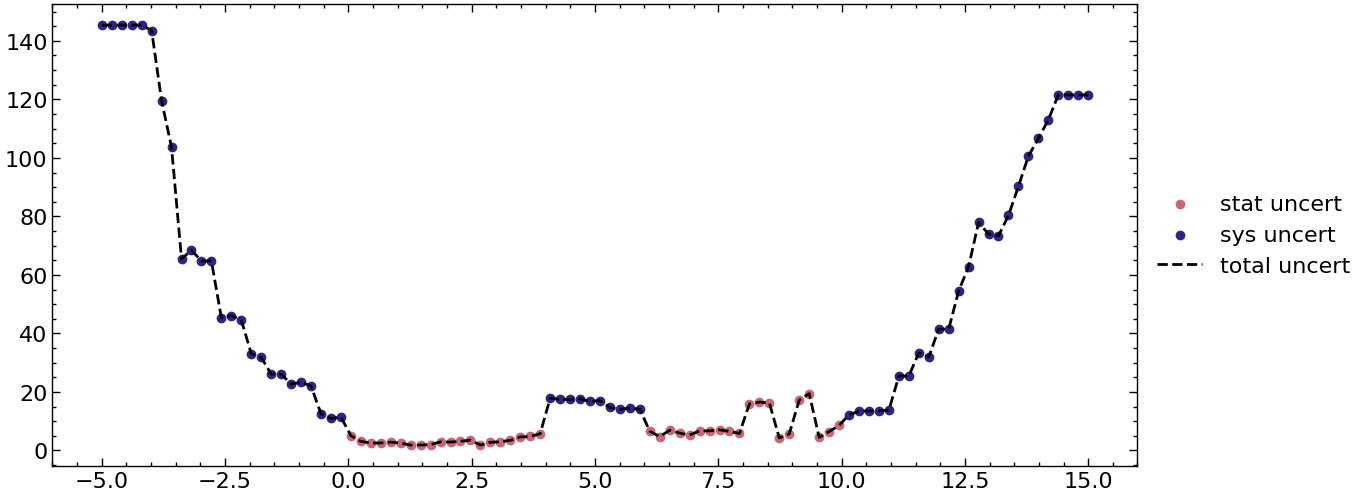

In [69]:
plt.figure(figsize=(14, 6))
plt.scatter(xx_in_domain, stat_uncert, label="stat uncert")
plt.scatter(xx_out_domain, sys_uncert, label="sys uncert")
plt.plot(xx, total_uncertainty, label="total uncert", c="k", ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


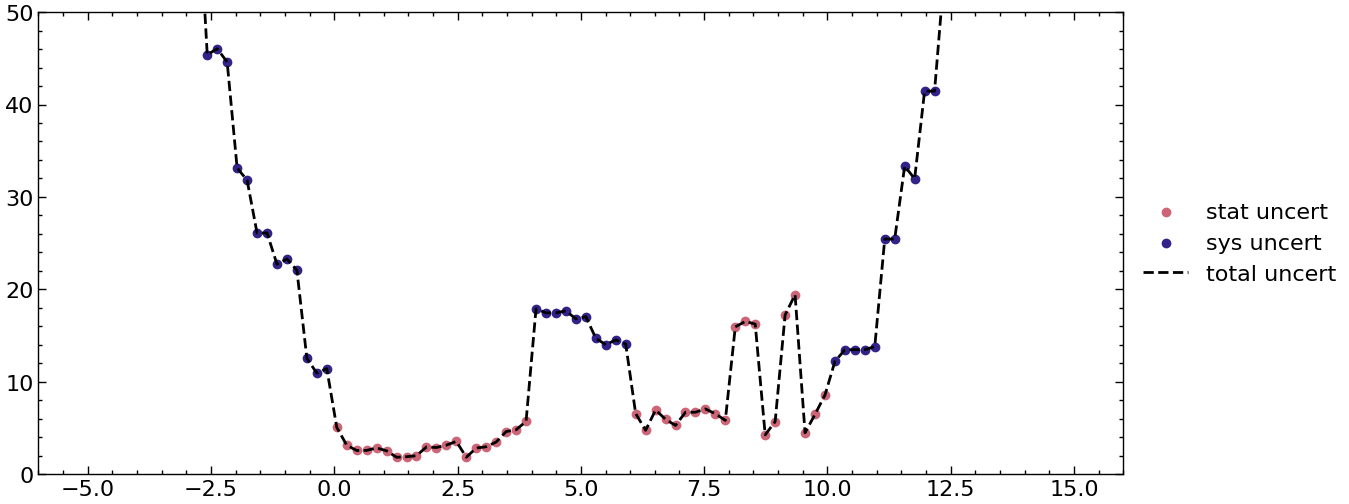

In [70]:
plt.figure(figsize=(14, 6))
plt.scatter(xx_in_domain, stat_uncert, label="stat uncert")
plt.scatter(xx_out_domain, sys_uncert, label="sys uncert")
plt.plot(xx, total_uncertainty, label="total uncert", c="k", ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 50)
plt.show()


In [71]:

yhats = {alpha: eqr_model.models[alpha].predict(X_train) for alpha in alphas}


coverage_fraction(
    y_train,
    yhats[0.05],
    yhats[0.95],
)

0.8844884488448845

In [72]:
yhats = {alpha: eqr_model.models[alpha].predict(X_test) for alpha in alphas}

coverage_fraction(
    y_test,
    yhats[0.05],
    yhats[0.95],
)

0.8366336633663366